In [136]:
# Imports and styling
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

plt.style.use('default')

In [137]:
# Initial dataset handling
"""
survival 	Survival 	            0 = No, 1 = Yes
pclass 	    Ticket class 	        1 = 1st, 2 = 2nd, 3 = 3rd
sex 	    Sex 	
Age 	    Age in years 	
sibsp 	    # of siblings / spouses aboard the Titanic 	
parch 	    # of parents / children aboard the Titanic 	
ticket 	    Ticket number 	
fare 	    Passenger fare 	
cabin 	    Cabin number 	
embarked 	Port of Embarkation 	C = Cherbourg, Q = Queenstown, S = Southampton
"""
df_train = pd.read_csv('input/train.csv', sep=',')
df_test = pd.read_csv('input/test.csv', sep=',')
ids_test = df_test["PassengerId"]

# Remove unusuable string parameters, plus cabin has many NaN values
df_train = df_train.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis=1)
df_test = df_test.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis=1)

# Map strings to numeric values
df_train["Sex"] = df_train["Sex"].map({"male": 0, "female": 1})
df_train["Embarked"] = df_train["Embarked"].map({"C": 0, "Q": 1, "S": 2})
df_test["Sex"] = df_test["Sex"].map({"male": 0, "female": 1})
df_test["Embarked"] = df_test["Embarked"].map({"C": 0, "Q": 1, "S": 2})

In [138]:
df_train.isna().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

In [139]:
df_test.isna().sum()

Pclass       0
Sex          0
Age         86
SibSp        0
Parch        0
Fare         1
Embarked     0
dtype: int64

In [140]:
# Fill in missing fare value
df_test["Fare"] = df_test["Fare"].replace(np.NaN, df_test["Fare"].mean())

# Fill in missing age values considering SibSp and Parch
age_cols = ["SibSp", "Parch", "Age"]
impute = IterativeImputer()

X_age = df_train[age_cols]
df_age = pd.DataFrame(np.round(impute.fit_transform(X_age)), columns=age_cols)
df_train["Age"] = df_age["Age"]

X_age = df_test[age_cols]
df_age = pd.DataFrame(np.round(impute.fit_transform(X_age)), columns=age_cols)
df_test["Age"] = df_age["Age"]

# Remove rows with empty embarked values from the training data
df_train = df_train.dropna().reset_index(drop=True)

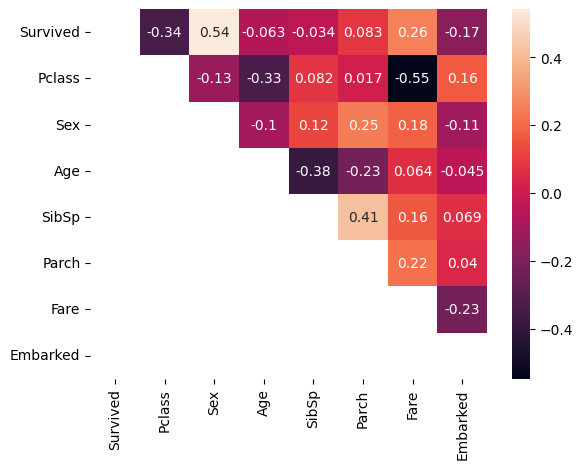

Age      0.062614
SibSp    0.034040
Parch    0.083151
Name: Survived, dtype: float64

In [141]:
# Correlation matrix to check for unusable values
corr_matrix = df_train.corr()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
plt.figure()
sns.heatmap(upper_tri, annot=True)
plt.show()

cor_target = abs(corr_matrix["Survived"])
to_drop = cor_target[cor_target < 0.1]
to_drop

In [142]:
# SibSp, Parch and Age have low correlation with the output parameter, so they're also removed
df_train = df_train.drop(["Age", "SibSp", "Parch"], axis=1)
df_test = df_test.drop(["Age", "SibSp", "Parch"], axis=1)

In [143]:
X_train = df_train.drop(["Survived"], axis=1)
y_train = df_train["Survived"]

In [144]:
# parameters = {'criterion':('gini', 'entropy'), 'max_depth':[2,3,4,5], 'max_features':['sqrt', 'log2'], 'max_leaf_nodes':[4,8,16,32]}
# dt2 = DecisionTreeClassifier()
# clf = GridSearchCV(dt2, parameters, return_train_score=True)
# clf.fit(X_train, y_train)
# results = pd.DataFrame(clf.cv_results_)
# results

In [145]:
cv = KFold(n_splits=10)
accuracies = list()
max_attributes = len(list(df_test))
depth_range = range(1, max_attributes + 1)

for depth in depth_range:
    fold_accuracy = []
    tree_model = DecisionTreeClassifier(max_depth=depth)
    for train_fold, valid_fold in cv.split(df_train):
        f_train = df_train.loc[train_fold]
        f_valid = df_train.loc[valid_fold]

        model = tree_model.fit(X_train, y_train)
        valid_acc = model.score(f_valid.drop(["Survived"], axis=1), f_valid["Survived"])
        fold_accuracy.append(valid_acc)

    avg = sum(fold_accuracy) / len(fold_accuracy)
    accuracies.append(avg)

df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
df = df[["Max Depth", "Average Accuracy"]]
print(df.to_string(index=False))

 Max Depth  Average Accuracy
         1          0.786249
         2          0.786287
         3          0.814390
         4          0.816650


In [146]:
dt = DecisionTreeClassifier(max_depth=3, min_impurity_decrease=0.01).fit(X_train, y_train)
 
training_score = dt.score(X_train, y_train)
print("Training set score: {:.4f}".format(training_score))

Training set score: 0.8099


In [147]:
prediction = dt.predict(df_test)

In [148]:
output = pd.DataFrame({"PassengerId" : ids_test, "Survived": prediction})
output.to_csv("submission.csv", index=False)

[Text(0.4444444444444444, 0.875, 'X[1] <= 0.5\ngini = 0.472\nsamples = 889\nvalue = [549, 340]'),
 Text(0.2222222222222222, 0.625, 'X[2] <= 26.269\ngini = 0.306\nsamples = 577\nvalue = [468, 109]'),
 Text(0.1111111111111111, 0.375, 'gini = 0.226\nsamples = 415\nvalue = [361, 54]'),
 Text(0.3333333333333333, 0.375, 'gini = 0.448\nsamples = 162\nvalue = [107, 55]'),
 Text(0.6666666666666666, 0.625, 'X[0] <= 2.5\ngini = 0.384\nsamples = 312\nvalue = [81, 231]'),
 Text(0.5555555555555556, 0.375, 'gini = 0.101\nsamples = 168\nvalue = [9, 159]'),
 Text(0.7777777777777778, 0.375, 'X[2] <= 23.35\ngini = 0.5\nsamples = 144\nvalue = [72, 72]'),
 Text(0.6666666666666666, 0.125, 'gini = 0.484\nsamples = 117\nvalue = [48, 69]'),
 Text(0.8888888888888888, 0.125, 'gini = 0.198\nsamples = 27\nvalue = [24, 3]')]

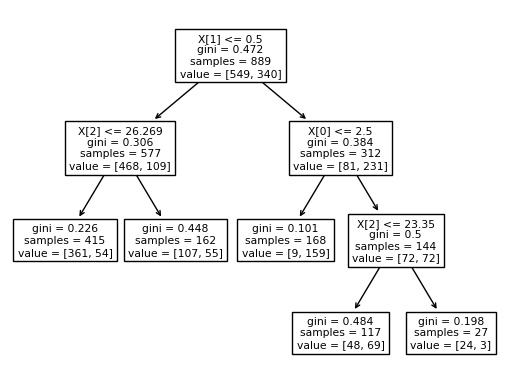

In [149]:
plot_tree(dt)